In [1]:
# Implimentation of a language model from the following research paper:
# https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt", 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
NUM_CHARS = len(stoi.keys())
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# Build the data set.

block_size = 3  # Context length.  How many letters do we take to predict the next.
X, Y = [], []

for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context) # Preceeding 3 letters
        Y.append(ix)      # Expected next letter (called labels in ML).
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]  # Crop and append.
X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [7]:
# We need to embed the inputs into a smaller tensor, since in practice the 
# number of input possibilities could be huge (27,000 in the case of words).
# So we need a "feature vector" that maps each context.  So a given context
# will get mapped into a feature vector.  We don't know what the feature 
# vector will be, so we will need to train it.  We will start it off as random
# numbers.  The shape must be NUM_POSSIBLE_WORDS by NUM_DIM_FEATURE_VEC
# The number of dimensions in the feature vector should be far smaller than
# the number of possible inputs.  In our character model case, we have 27 possible
# inputs, and we will map it down to a 2-D feature vector.
C = torch.randn((27, 2))

# You can index into this tensor to get the feature vector for any character.  
# For example the letter 'e' is 5, so we can get the feature vector for 'e':
C[5]

tensor([1.1134, 0.4592])

In [8]:
# Torch is pretty awesome though.  We can index a query of letters all at once
# by giving it a more complex input.  Instead of an integer, you can give it
# a whole tensor full of letter IDs.  In our case, it will be our inputs X
C[X].shape
# Note that it produces a LARGER tensor!  It has a first dimension as large as our
# input data set.  The second dimension is as big as block size since each input
# data set has block_size characters in it.  Then for each of those, we have the 
# 2-D feature vector.

torch.Size([228146, 3, 2])

In [9]:
# Now we can embedd the inputs using the feature vector.
embedding = C[X]
embedding.shape
# At this point, we have a tensor that is:
#   NUM_TRAINING_EXAMPLES by CONTEXT_SIZE (block_size) by NUM_DIM_FEATURE_VEC

# This embedding is the first layer of our network (layer 0).

torch.Size([228146, 3, 2])

In [10]:
# For the next layer of our network we are going to set up a list of neurons.
NUM_LAYER1_NEURONS = 100
# The number of inputs will be block_size times the feature vector size.
L1_INPUT_SIZE = embedding.shape[1] * embedding.shape[2]
# We can now build our layer 1 weights and biases.
W1 = torch.randn((L1_INPUT_SIZE, NUM_LAYER1_NEURONS))
b1 = torch.randn(100)

W1.shape

torch.Size([6, 100])

In [11]:
# We now need to map our embeddings to the proper input shape of layer 1.
# We could cat together the 2nd and 3rd dimensions, but that would copy the
# entire tensor.  It's more efficient to use the "view" function to just
# re-map the shape of the tensor to what we need.  So we need to leave the
# first dimension as-is (the list of inputs), and the next 2 dimensions should 
# be viewed together.  The size is the multiplication of the 2 dimension sizes.
embedding.view(-1, L1_INPUT_SIZE).shape

torch.Size([228146, 6])

In [12]:
# We can now computer our hidden layer outputs.  It is just:
#   h = Wx + b -> tanh() for non-linearity
h = torch.tanh(embedding.view(-1, L1_INPUT_SIZE) @ W1 + b1)
h.shape

torch.Size([228146, 100])

In [13]:
# Our second layer is going to map from the 100 neurons in the first layer to
# 27 outputs.  The probability for each character.
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

# We can multiply to get our output, logits = W2 x + b
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [14]:
# Exponitiate the logs to get counts
counts = logits.exp()

# Convert to probabilities.
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([228146, 27])

In [15]:
# Spot-check the predictions for every output.
prob[torch.arange(Y.shape[0]), Y]

tensor([4.7997e-11, 8.5683e-07, 6.5837e-17,  ..., 6.6609e-08, 4.4483e-07,
        6.2087e-10])

In [16]:
# Calculate the loss.
loss = -prob[torch.arange(Y.shape[0]), Y].log().mean()
loss

tensor(16.7701)

In [37]:
# Okay, now do it the clean way.

g = torch.Generator().manual_seed(1337)
C = torch.randn((27, 2))
W1 = torch.randn((L1_INPUT_SIZE, NUM_LAYER1_NEURONS))
b1 = torch.randn(NUM_LAYER1_NEURONS)
W2 = torch.randn((NUM_LAYER1_NEURONS, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters) # Show number of parameters in the network.

3481

In [41]:
for train_count in range(8000):
    # Build a small batch of training data.  We want to select random items from our
    # huge training set.  So use random int to pick 32 items out of our huge list.
    batch_indexs = torch.randint(0, X.shape[0], (32,))

    # Forward pass.
    embedding = C[X[batch_indexs]]
    h = torch.tanh(embedding.view(-1, L1_INPUT_SIZE) @ W1 + b1)
    logits = h @ W2 + b2

    # These next three are "grading" the system.  Classification is a typical AI task,
    # so they call the grading against truth "cross entropy".  We can just use the function.
    # Using the function in torch is far more efficient than calculating all of the intermediate
    # values and doing the math explicitly.
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(Y.shape[0]), Y].log().mean()
    loss = F.cross_entropy(logits, Y[batch_indexs])

    # Backward pass.
    TRAINING_RATE = 0.01

    # First reset the gradient on all params.
    for p in parameters:
        p.grad = None
    loss.backward()
    # Update values.
    for p in parameters:
        p.data += -TRAINING_RATE * p.grad
print(loss.item())

2.2478997707366943


In [42]:
embedding = C[X[batch_indexs]]
h = torch.tanh(embedding.view(-1, L1_INPUT_SIZE) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y[batch_indexs])
loss.item()

2.2147510051727295

In [43]:
# With a trained model we can now sample from it.

# g = torch.Generator().manual_seed(2147483647 + 1)

for _ in range(25):
    out = []
    context = [0] * block_size
    while True:
        embedding = C[torch.tensor(context)]  # (1, block_size, d)
        h = torch.tanh(embedding.view(-1, L1_INPUT_SIZE) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        next_letter_i = torch.multinomial(probs, num_samples=1, generator=g).item()
        if next_letter_i == 0:
            break
        out.append(itos[next_letter_i])
        context = context[1:] + [next_letter_i]
    print(''.join(out))

caoldaanyx
baz
den
ivaedohie
ra
jara
mees
ba
mirohas
hvee
mmylezancesra
xze
mtynihe
kica
sangeholys
iuheliy
kiy
mannlir
aha
mtriahir
haclesnan
asehulil
arut
dayzyrlayni
ey


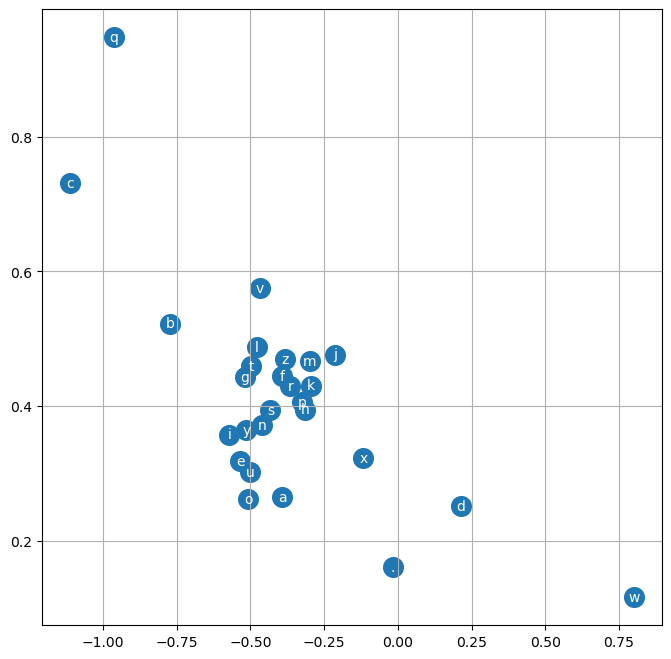

In [46]:
# Visualize dimensions 0 and 1 of the embedding matrix C for all characters.
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')